# 03 - Stationary Iterative Methods

---

### 1. Introduction

While direct methods like Gaussian Elimination and LU Decomposition provide an exact solution in a finite number of steps (ignoring round-off errors), **iterative methods** offer a different approach. They start with an initial guess for the solution and progressively refine it through a series of iterations until it is hopefully "close enough" to the true solution.

These methods are particularly powerful for very **large and sparse systems** (matrices with many zero entries), where direct methods would be computationally too expensive or would require too much memory.

A **stationary iterative method** has the general form:
$$ x^{(k+1)} = Bx^{(k)} + c $$
Where $x^{(k)}$ is the solution vector at the $k$-th iteration. The method is called "stationary" because the iteration matrix $B$ and the vector $c$ remain **fixed** throughout the process.

### 2. The Infinity Norm and Stopping Criterion

To measure the difference between successive solution vectors and decide when to stop, we need a way to determine the "size" or "magnitude" of a vector. A common choice is the **infinity norm** ($L_\infty$-norm).

The infinity norm of a vector $x$ is simply the maximum absolute value of its components:
$$ ||x||_\infty = \max_{1 \le i \le n} |x_i| $$

#### Stopping Criterion
Our primary stopping criterion will be the **relative error** between two consecutive iterations, measured using the infinity norm. We stop when this error falls below a given tolerance $\epsilon$.
$$ \frac{||x^{(k)} - x^{(k-1)}||_\infty}{||x^{(k)}||_\infty} < \epsilon $$

To prevent infinite loops in cases of divergence, we must also set a **maximum number of iterations**.

### 3. The Jacobi Method

The Jacobi method is one of the simplest iterative techniques. The core idea is to rearrange each equation in the system $Ax=b$ to isolate one variable.

Starting with the system:
$$ 
\begin{cases}
a_{11}x_1 + a_{12}x_2 + \cdots + a_{1n}x_n = b_1 \\
a_{21}x_1 + a_{22}x_2 + \cdots + a_{2n}x_n = b_2 \\
\vdots \\
a_{n1}x_1 + a_{n2}x_2 + \cdots + a_{nn}x_n = b_n
\end{cases}
$$

We can isolate each variable $x_i$ (assuming $a_{ii} \neq 0$):
$$ x_i = \frac{1}{a_{ii}} \left( b_i - \sum_{j \neq i} a_{ij}x_j \right) $$

This rearrangement forms the basis of the iterative process. To get the next approximation $x^{(k)}$, we plug the values from the *entire* previous approximation $x^{(k-1)}$ into the right-hand side of the equations:
$$ x_i^{(k)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j \neq i} a_{ij}x_j^{(k-1)} \right) $$

#### Convergence Analysis: The Row-Sum Criterion
A key question for any iterative method is: will it converge? A sufficient (but not necessary) condition for convergence is the **row-sum criterion**, which is met if the matrix is **strictly diagonally dominant**.

A matrix is strictly diagonally dominant if, for every row, the absolute value of the diagonal element is greater than the sum of the absolute values of all other elements in that row.

Formally, we define for each row $i$:
$$ \rho_i = \sum_{\substack{j=1 \\ j \ne i}}^n \left| \frac{a_{ij}}{a_{ii}} \right| $$

If $\rho = \max_i(\rho_i) < 1$, then the Jacobi method is **guaranteed to converge** for any initial guess $x^{(0)}$.

### 4. Jacobi Method: Implementation and Example

**Example System:**
$$ 
\begin{cases}
4x_1 + 0.24x_2 - 0.08x_3 = 8 \\
0.03x_1 + 3x_2 - 0.15x_3 = 9 \\
0.04x_1 - 0.08x_2 + 4x_3 = 20
\end{cases}
$$

In [1]:
import numpy as np
import pandas as pd

def jacobi_method(A, b, x0, tol=1e-6, max_iter=100):
    """Solves Ax=b using the Jacobi iterative method."""
    n = len(b)
    x = x0.copy()
    history = [x0.copy()]

    for k in range(max_iter):
        x_prev = x.copy()
        for i in range(n):
            sigma = np.dot(A[i, :i], x_prev[:i]) + np.dot(A[i, i+1:], x_prev[i+1:])
            x[i] = (b[i] - sigma) / A[i, i]
        
        history.append(x.copy())
        
        # Check for convergence
        error = np.linalg.norm(x - x_prev, np.inf) / (np.linalg.norm(x, np.inf) + 1e-12)
        if error < tol:
            print(f"Jacobi converged after {k+1} iterations.")
            return x, pd.DataFrame(history)
    
    print("Jacobi failed to converge within the maximum number of iterations.")
    return x, pd.DataFrame(history)

# --- Setup for the example ---
A_ex = np.array([
    [4, 0.24, -0.08],
    [0.03, 3, -0.15],
    [0.04, -0.08, 4]
])

b_ex = np.array([8, 9, 20])
x0_ex = np.zeros(3)

# Check the convergence criterion
diag = np.diag(np.abs(A_ex))
off_diag = np.sum(np.abs(A_ex), axis=1) - diag
if np.all(diag > off_diag):
    print("Matrix is strictly diagonally dominant. Jacobi method will converge.")
else:
    print("Matrix is not strictly diagonally dominant. Convergence is not guaranteed.")

# Solve the system
jacobi_sol, jacobi_hist = jacobi_method(A_ex, b_ex, x0_ex, max_iter=3)
print("\nResults after 3 iterations:")
jacobi_hist.columns = ['x1', 'x2', 'x3']
display(jacobi_hist)

Matrix is strictly diagonally dominant. Jacobi method will converge.
Jacobi failed to converge within the maximum number of iterations.

Results after 3 iterations:


,x1,x2,x3
0,0.000,0.0000,0.0000
1,2.000,3.0000,5.0000
2,1.920,3.2300,5.0400
3,1.907,3.2328,5.0454


### 5. The Gauss-Seidel Method

The Gauss-Seidel method is a simple but effective refinement of the Jacobi method. The key difference is that it uses the **most recently updated values** of the variables as soon as they become available within the same iteration.

For example, when calculating $x_2^{(k)}$, it uses the newly computed $x_1^{(k)}$ instead of the old $x_1^{(k-1)}$. This generally leads to a faster rate of convergence.

The iterative formula becomes:
$$ x_i^{(k)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j < i} a_{ij}x_j^{(k)} - \sum_{j > i} a_{ij}x_j^{(k-1)} \right) $$

The convergence criterion (strict diagonal dominance) is the same as for the Jacobi method.

### 6. Gauss-Seidel: Implementation and Example

In [2]:
def gauss_seidel_method(A, b, x0, tol=1e-6, max_iter=100):
    """Solves Ax=b using the Gauss-Seidel iterative method."""
    n = len(b)
    x = x0.copy()
    history = [x0.copy()]

    for k in range(max_iter):
        x_prev = x.copy()
        for i in range(n):
            # Note the use of the updated x vector inside the loop
            sigma = np.dot(A[i, :i], x[:i]) + np.dot(A[i, i+1:], x_prev[i+1:])
            x[i] = (b[i] - sigma) / A[i, i]
        
        history.append(x.copy())
        
        # Check for convergence
        error = np.linalg.norm(x - x_prev, np.inf) / (np.linalg.norm(x, np.inf) + 1e-12)
        if error < tol:
            print(f"Gauss-Seidel converged after {k+1} iterations.")
            return x, pd.DataFrame(history)
    
    print("Gauss-Seidel failed to converge within the maximum number of iterations.")
    return x, pd.DataFrame(history)

# Solve the same system with Gauss-Seidel
gs_sol, gs_hist = gauss_seidel_method(A_ex, b_ex, x0_ex, max_iter=3)
print("\nResults after 3 iterations:")
gs_hist.columns = ['x1', 'x2', 'x3']
display(gs_hist)

Gauss-Seidel failed to converge within the maximum number of iterations.

Results after 3 iterations:


,x1,x2,x3
0,0.000000,0.000000,0.000000
1,2.000000,2.980000,5.039600
2,1.921992,3.232760,5.045435
3,1.906943,3.233202,5.045595


### 7. Comparison and Summary

Let's solve the system to convergence and compare the performance of the two methods.

Jacobi converged after 7 iterations.
Gauss-Seidel converged after 6 iterations.
--- Final Solutions ---
Jacobi:       [1.90691927 3.23321056 5.04559502]
Gauss-Seidel: [1.90691927 3.23321056 5.04559502]


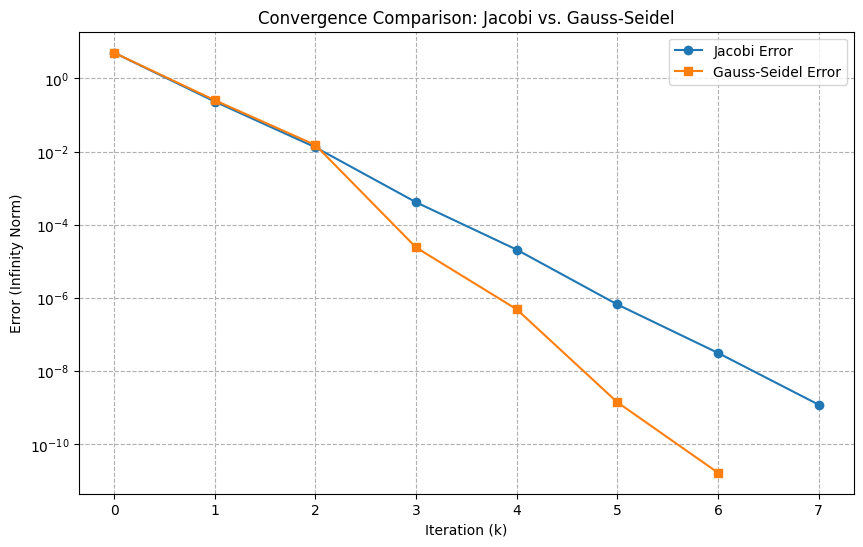

In [3]:
import matplotlib.pyplot as plt

# Solve to convergence
jacobi_sol_final, jacobi_hist_final = jacobi_method(A_ex, b_ex, x0_ex, tol=1e-8)
gs_sol_final, gs_hist_final = gauss_seidel_method(A_ex, b_ex, x0_ex, tol=1e-8)

print("--- Final Solutions ---")
print(f"Jacobi:       {jacobi_sol_final}")
print(f"Gauss-Seidel: {gs_sol_final}")

# Calculate the true solution for error comparison
true_sol = np.linalg.solve(A_ex, b_ex)

# Calculate error at each iteration
jacobi_errors = [np.linalg.norm(x - true_sol, np.inf) for x in jacobi_hist_final.values]
gs_errors = [np.linalg.norm(x - true_sol, np.inf) for x in gs_hist_final.values]

plt.figure(figsize=(10, 6))
plt.semilogy(jacobi_errors, 'o-', label='Jacobi Error')
plt.semilogy(gs_errors, 's-', label='Gauss-Seidel Error')
plt.title('Convergence Comparison: Jacobi vs. Gauss-Seidel')
plt.xlabel('Iteration (k)')
plt.ylabel('Error (Infinity Norm)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

The plot clearly shows that for this (and many other) problems, **Gauss-Seidel converges significantly faster** than Jacobi. The error drops much more steeply per iteration.

| Property                  | **Jacobi** | **Gauss-Seidel** |
|---------------------------|---------------------------------------------|------------------------------------------------|
| **Core Idea** | Uses only values from the previous iteration. | Uses the newest available values immediately.    |
| **Convergence Speed** | Generally slower.                           | Generally faster.                              |
| **Parallelization** | Easy to parallelize (all updates are independent). | Difficult to parallelize (updates are sequential). |
| **Implementation** | Requires two vectors (current and previous).  | Can be implemented "in-place" with one vector.   |
| **Convergence Condition** | Strict diagonal dominance is sufficient.    | Strict diagonal dominance is sufficient.       |